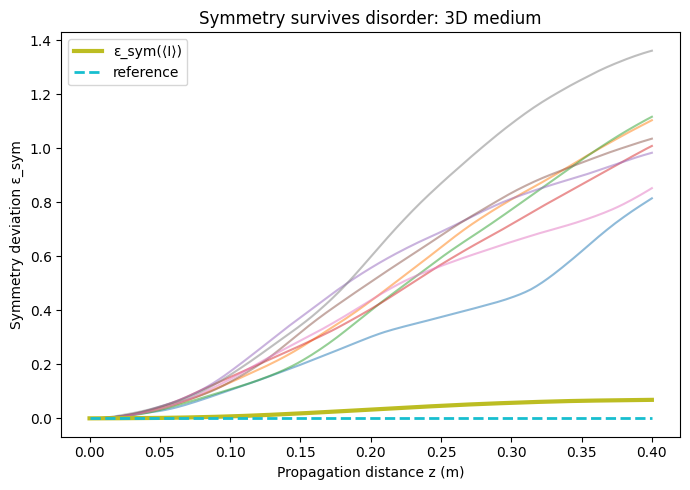

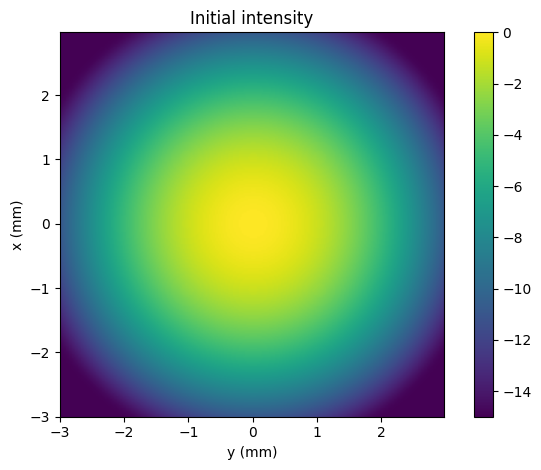

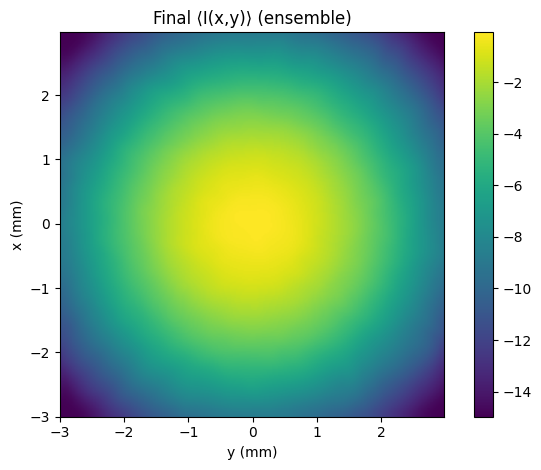

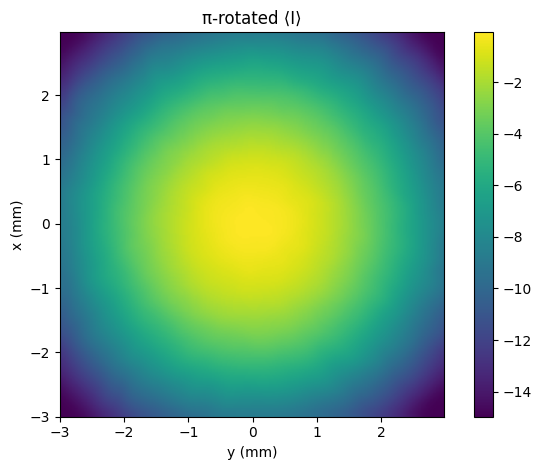

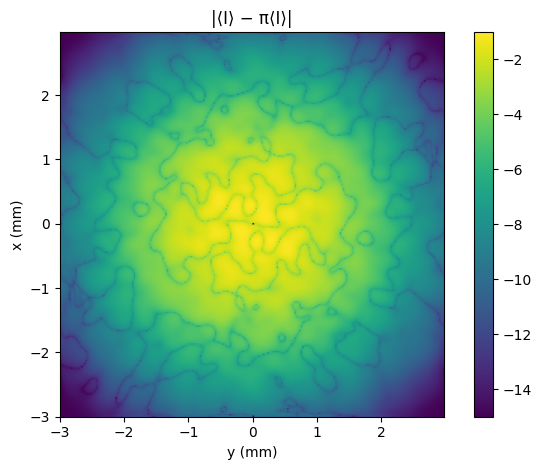


==== FINAL NUMBERS ====
ε_sym(reference final) = 1.679e-14
⟨ε_sym⟩ single-shot   = 1.032
ε_sym(ensemble)       = 6.845e-02


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Utility functions
# ============================================================

def gaussian_beam_2d(X, Y, w0):
    return np.exp(-(X**2 + Y**2)/(2*w0**2))

def pi_rotate(I):
    J = I[::-1, ::-1]
    if I.shape[0] % 2 == 0:
        J = np.roll(J, 1, axis=0)
    if I.shape[1] % 2 == 0:
        J = np.roll(J, 1, axis=1)
    return J

def eps_sym(I):
    return np.sum(np.abs(I - pi_rotate(I))) / (np.sum(I) + 1e-15)

def correlated_noise_2d(N, dx, corr_len, rng):
    k = 2*np.pi*np.fft.fftfreq(N, d=dx)
    KX, KY = np.meshgrid(k, k, indexing='ij')
    K2 = KX**2 + KY**2

    noise = rng.normal(size=(N,N)) + 1j*rng.normal(size=(N,N))
    filt = np.exp(-0.5 * K2 * corr_len**2)
    field = np.fft.ifft2(noise * filt).real
    field -= field.mean()
    field /= (field.std() + 1e-15)
    return field

def diffraction_operator(N, dx, dz, k0):
    k = 2*np.pi*np.fft.fftfreq(N, d=dx)
    KX, KY = np.meshgrid(k, k, indexing='ij')
    return np.exp(-1j * (KX**2 + KY**2) * dz / (2*k0))

def split_step(E, expD, V, dz):
    E = np.exp(-1j*V*dz/2) * E
    E = np.fft.ifft2(np.fft.fft2(E) * expD)
    E = np.exp(-1j*V*dz/2) * E
    return E

# ============================================================
# MAIN SIMULATION (OPTION B)
# ============================================================

def run_symmetry_vs_z():
    # -------------------------------
    # Parameters
    # -------------------------------
    seed = 11
    rng = np.random.default_rng(seed)

    lam = 800e-9
    k0 = 2*np.pi/lam

    L = 6e-3
    N = 256
    dx = L/N

    z_total = 0.4
    dz = 2e-3
    nsteps = int(z_total/dz)

    w0 = 0.6e-3
    corr_len_xy = 0.25e-3
    corr_len_z_steps = 10.0
    sigma_dn = 2e-6

    Nreal = 300
    n_show = 8

    # -------------------------------
    # Grid and initial field
    # -------------------------------
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    X, Y = np.meshgrid(x, x, indexing='ij')

    E0 = gaussian_beam_2d(X, Y, w0).astype(np.complex128)

    expD = diffraction_operator(N, dx, dz, k0)

    a = np.exp(-1.0 / corr_len_z_steps)

    # -------------------------------
    # Reference (no disorder)
    # -------------------------------
    E = E0.copy()
    eps_ref = np.zeros(nsteps+1)
    eps_ref[0] = eps_sym(np.abs(E)**2)

    for m in range(nsteps):
        E = split_step(E, expD, 0.0, dz)
        eps_ref[m+1] = eps_sym(np.abs(E)**2)

    # -------------------------------
    # Single-shot microstates
    # -------------------------------
    eps_single = np.zeros((Nreal, nsteps+1))
    I_mean_z = np.zeros((nsteps+1, N, N))

    for r in range(Nreal):
        E = E0.copy()
        dn_state = np.zeros((N,N))

        eps_single[r,0] = eps_sym(np.abs(E)**2)
        I_mean_z[0] += np.abs(E)**2

        for m in range(nsteps):
            eta = correlated_noise_2d(N, dx, corr_len_xy, rng)
            dn_state = a*dn_state + np.sqrt(1-a*a)*eta
            V = k0 * sigma_dn * dn_state

            E = split_step(E, expD, V, dz)

            eps_single[r,m+1] = eps_sym(np.abs(E)**2)
            I_mean_z[m+1] += np.abs(E)**2

    I_mean_z /= Nreal
    eps_ens = np.array([eps_sym(I_mean_z[m]) for m in range(nsteps+1)])

    # -------------------------------
    # Plot ε_sym(z)
    # -------------------------------
    z = np.linspace(0, z_total, nsteps+1)

    plt.figure(figsize=(7,5))

    for i in range(min(n_show, Nreal)):
        plt.plot(z, eps_single[i], alpha=0.5)

    plt.plot(z, eps_ens, linewidth=3, label="ε_sym(⟨I⟩)")
    plt.plot(z, eps_ref, "--", linewidth=2, label="reference")

    plt.xlabel("Propagation distance z (m)")
    plt.ylabel("Symmetry deviation ε_sym")
    plt.title("Symmetry survives disorder: 3D medium")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Final-plane maps
    # -------------------------------
    extent = [x[0]*1e3, x[-1]*1e3, x[0]*1e3, x[-1]*1e3]

    def show(I, title):
        plt.figure()
        plt.imshow(np.log10(I+1e-15), origin="lower", extent=extent)
        plt.title(title)
        plt.xlabel("y (mm)")
        plt.ylabel("x (mm)")
        plt.colorbar()
        plt.tight_layout()

    show(np.abs(E0)**2, "Initial intensity")
    show(I_mean_z[-1], "Final ⟨I(x,y)⟩ (ensemble)")
    show(pi_rotate(I_mean_z[-1]), "π-rotated ⟨I⟩")
    show(np.abs(I_mean_z[-1]-pi_rotate(I_mean_z[-1])), "|⟨I⟩ − π⟨I⟩|")
    plt.show()

    print("\n==== FINAL NUMBERS ====")
    print(f"ε_sym(reference final) = {eps_ref[-1]:.3e}")
    print(f"⟨ε_sym⟩ single-shot   = {eps_single[:,-1].mean():.3f}")
    print(f"ε_sym(ensemble)       = {eps_ens[-1]:.3e}")

# ============================================================
# RUN
# ============================================================

if __name__ == "__main__":
    run_symmetry_vs_z()

